## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import swifter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from src.features import add_calendar_features
from src.evaluation import Evaluation
from src.plots import plot_metrics, plot_time_series

# configurando notebook
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

# constantes
EVAL_PATH = 'data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("data/test_df.csv", parse_dates=['ds'])

In [3]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)


features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

In [4]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter'],
      dtype='object')

## **Random Forest Regression**

In [5]:
def random_forest(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = RandomForestRegressor(
        n_estimators=1000, 
        max_depth=10, 
        min_samples_split=4, 
        random_state=1001
    )
    
    m.fit(
        X=train.iloc[:,3:], 
        y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(X=fcst_df.iloc[:,3:])

    return fcst_df

In [6]:
# aplicando modelo para cada série
rf_fcst = (
    features_train_df
        .swifter
        .groupby("unique_id")
        .apply(random_forest)
        .reset_index(drop=True)
)

  0%|          | 0/15 [00:00<?, ?it/s]

2025-01-15 16:44:22,696	INFO worker.py:1821 -- Started a local Ray instance.


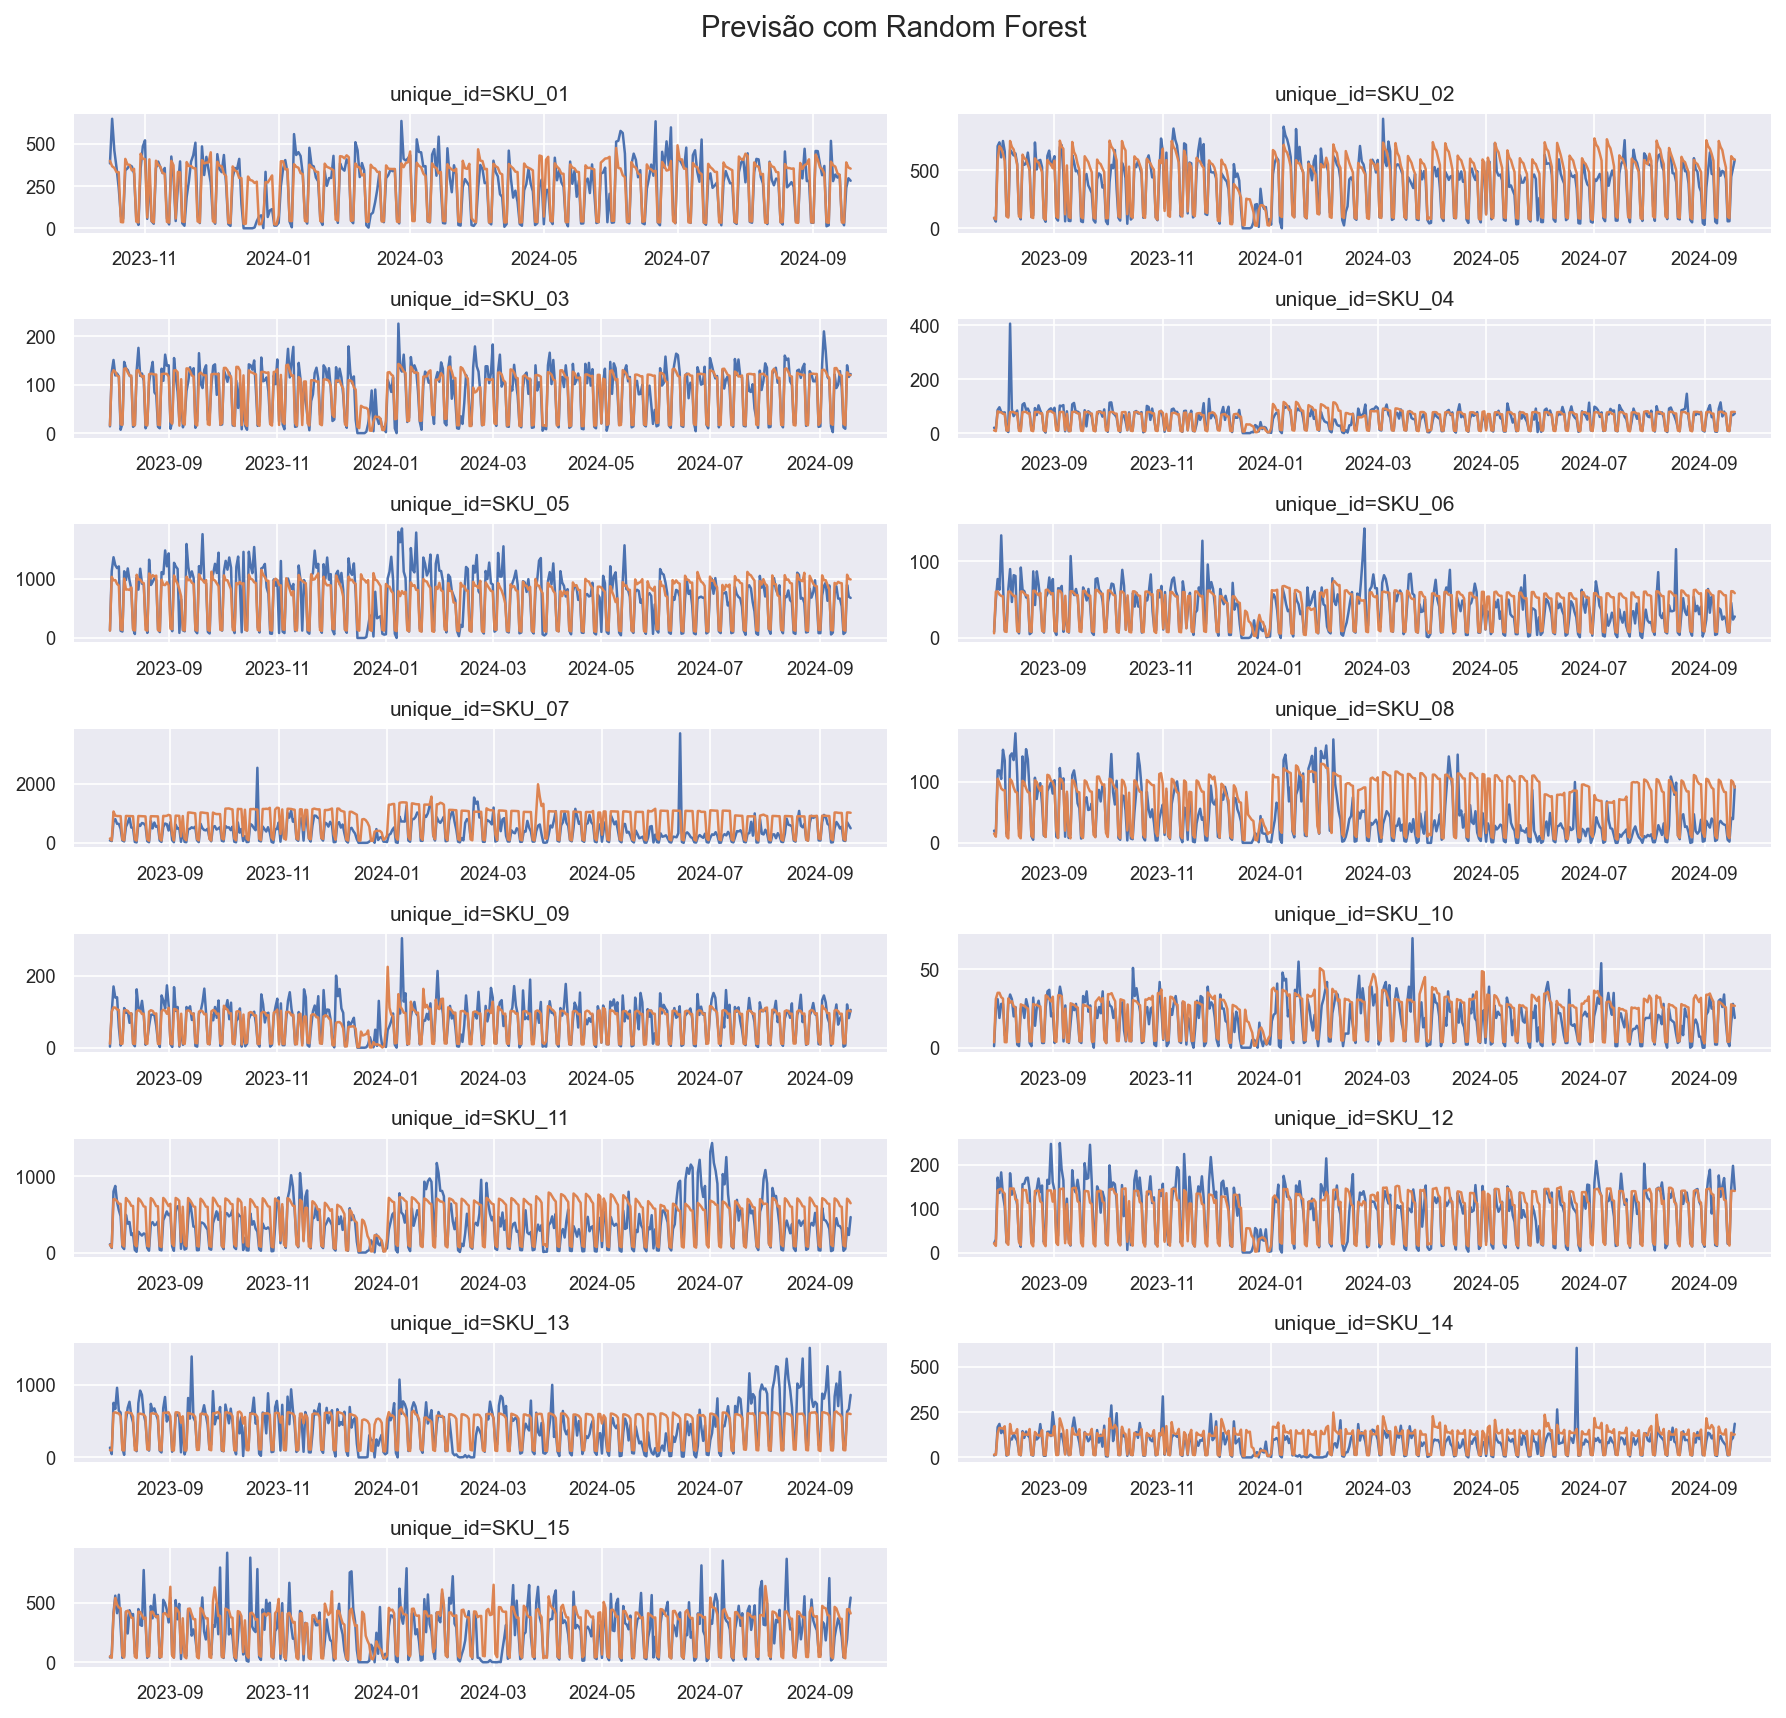

In [7]:
fig1 = plot_time_series(
    df=rf_fcst, data_cols=['y','y_pred'], title='Previsão com Random Forest'
)

In [8]:
rf_eval = Evaluation(rf_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Random Forest')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,64.34,8707.06,93.31,0.69
SKU_02,86.93,14106.39,118.77,0.73
SKU_03,17.62,639.89,25.30,0.77
SKU_04,13.61,608.32,24.66,0.58
SKU_05,196.46,85031.68,291.60,0.60
SKU_06,12.93,327.49,18.10,0.53
SKU_07,382.26,243013.25,492.96,-0.70
SKU_08,35.29,2122.73,46.07,-0.26
SKU_09,19.39,926.37,30.44,0.65
SKU_10,6.94,89.23,9.45,0.44


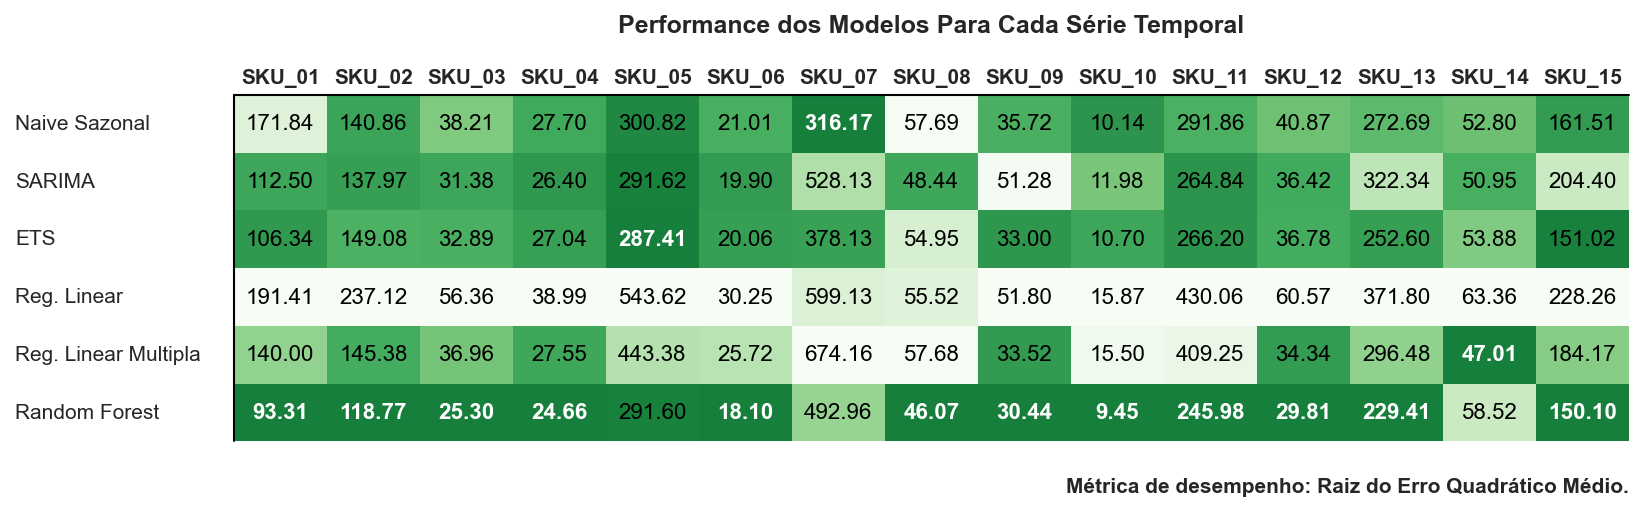

In [9]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 3))